In [2]:
import matplotlib.pyplot as plt
import pickle

In [3]:
import time
import random
from math import dist
from statistics import mean

import cv2
import numpy as np
import pyastar2d
import requests as req

from utils import Controller, grabScreen
# disable proxies
requests = req.Session()
requests.trust_env = False


In [4]:
def createLineIterator(P1, P2, img):
  """
  Produces and array that consists of the coordinates and intensities of each pixel in a line between two points

  Parameters:
      -P1: a numpy array that consists of the coordinate of the first point (x,y)
      -P2: a numpy array that consists of the coordinate of the second point (x,y)
      -img: the image being processed

  Returns:
      -it: a numpy array that consists of the coordinates and intensities of each pixel in the radii (shape: [numPixels, 3], row = [x,y,intensity])     
  """
  #define local variables for readability
  imageH = img.shape[0]
  imageW = img.shape[1]
  P1X = P1[0]
  P1Y = P1[1]
  P2X = P2[0]
  P2Y = P2[1]

  #difference and absolute difference between points
  #used to calculate slope and relative location between points
  dX = P2X - P1X
  dY = P2Y - P1Y
  dXa = np.abs(dX)
  dYa = np.abs(dY)

  #predefine numpy array for output based on distance between points
  itbuffer = np.empty(shape=(np.maximum(dYa,dXa),3),dtype=np.float32)
  itbuffer.fill(np.nan)

  #Obtain coordinates along the line using a form of Bresenham's algorithm
  negY = P1Y > P2Y
  negX = P1X > P2X
  if P1X == P2X: #vertical line segment
      itbuffer[:,0] = P1X
      if negY:
          itbuffer[:,1] = np.arange(P1Y - 1,P1Y - dYa - 1,-1)
      else:
          itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)              
  elif P1Y == P2Y: #horizontal line segment
      itbuffer[:,1] = P1Y
      if negX:
          itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
      else:
          itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
  else: #diagonal line segment
      steepSlope = dYa > dXa
      if steepSlope:
          slope = dX.astype(np.float32)/dY.astype(np.float32)
          if negY:
              itbuffer[:,1] = np.arange(P1Y-1,P1Y-dYa-1,-1)
          else:
              itbuffer[:,1] = np.arange(P1Y+1,P1Y+dYa+1)
          itbuffer[:,0] = (slope*(itbuffer[:,1]-P1Y)).astype(np.int) + P1X
      else:
          slope = dY.astype(np.float32)/dX.astype(np.float32)
          if negX:
              itbuffer[:,0] = np.arange(P1X-1,P1X-dXa-1,-1)
          else:
              itbuffer[:,0] = np.arange(P1X+1,P1X+dXa+1)
          itbuffer[:,1] = (slope*(itbuffer[:,0]-P1X)).astype(np.int) + P1Y

  #Remove points outside of image
  colX = itbuffer[:,0]
  colY = itbuffer[:,1]
  itbuffer = itbuffer[(colX >= 0) & (colY >=0) & (colX<imageW) & (colY<imageH)]

  #Get intensities from img ndarray
  itbuffer[:,2] = img[itbuffer[:,1].astype(np.uint),itbuffer[:,0].astype(np.uint)]

  return itbuffer

def getPointsInRadius(center_point, all_points, radius = 30):
  center = np.array([center_point['Y'],center_point['X']])
  all_points = np.array(all_points)
  bounding_box_lowerleft = center - np.array([radius, radius])
  bounding_box_upperright = center + np.array([radius, radius])
  in_box_points = all_points[(all_points[:, 0] < bounding_box_upperright[0]) & (all_points[:,0] > bounding_box_lowerleft[0]) & (all_points[:, 1] < bounding_box_upperright[1]) & (all_points[:,1] > bounding_box_lowerleft[1])]
  # Use squared to avoid cost of sqrt
  radius_squared = radius**2
  in_circle_points = in_box_points[((in_box_points[:, 0] - center[0])**2 + (in_box_points[:, 1] - center[1])**2) <= radius_squared ]
  return in_circle_points


def sortByHSV(img, h1, s1, v1, h2, s2, v2):
  minimap_blurred = cv2.medianBlur(img,3)
  hsv = cv2.cvtColor(minimap_blurred, cv2.COLOR_BGR2HSV )

  # формируем начальный и конечный цвет фильтра
  h_min = np.array((h1, s1, v1), np.uint8)
  h_max = np.array((h2, s2, v2), np.uint8)

  # накладываем фильтр на кадр в модели HSV
  thresh = cv2.inRange(hsv, h_min, h_max)
  kernel = np.ones((5,5),np.uint8)
  thresh = cv2.dilate(thresh,kernel,iterations = 2)
  return thresh


In [5]:
class PoeBot:
  window_pos_x = 0
  window_pos_y = 0
  window_pos_width = 0
  window_pos_height = 0

  # 1 passable, 0 - non passable
  
  def __init__(self,bot_controls:Controller) -> None:
    self.bot_controls = bot_controls
    self.poe_hud_endpoint = "http://127.0.0.1:50002"

  def getPositionOfThePointOnTheScreen(self,y,x):
    '''
    supposed to translate grid pos (y, x) to position in a game window
    returns [x,y] on the screen, not the display, use self.convertPosXY(x,y)
    '''
    if self.terrain_image is None: raise "self.terrain_image is None"
    # cos map is upside down
    y = self.terrain_image.shape[0] - y
    r = requests.get(f'{self.poe_hud_endpoint}/positionOnScreen?y={y}&x={x}')
    data = r.json()

    return data

  def getWholeData(self):
    r = requests.get(f'{self.poe_hud_endpoint}/gameInfo?type=full')
    data = r.json()
    return data
  
  def getInstanceData(self):
    r = requests.get(f'{self.poe_hud_endpoint}/gameInfo')
    data = r.json()
    return data

  def refreshTerrainData(self, data, refresh_visited = True):
    terrain_data = data['terrain_string'].split('\r\n')[:-1]
    img = np.asarray(list(map(lambda l: np.fromstring(l, 'int8'), terrain_data)))
    self.terrain_image = img
    
    # 1 passable, 0 - non passable
    ret, self.passable = cv2.threshold(cv2.convertScaleAbs(self.terrain_image),50,1,cv2.THRESH_BINARY)

    if refresh_visited is True: 
      self.visited_area = np.zeros((self.terrain_image.shape[0], self.terrain_image.shape[1]), dtype=np.uint8)

    self.terrain_for_a_star = self.terrain_image.copy()
    self.terrain_for_a_star = self.terrain_for_a_star.astype(np.float32)

    self.terrain_for_a_star[self.terrain_for_a_star < 50] = 2047
    self.terrain_for_a_star[self.terrain_for_a_star == 50] = 100
    self.terrain_for_a_star[self.terrain_for_a_star == 51] = 25
    self.terrain_for_a_star[self.terrain_for_a_star == 52] = 5
    self.terrain_for_a_star[self.terrain_for_a_star == 53] = 1
    self.terrain_for_a_star[self.terrain_for_a_star == 54] = 0.05
    self.terrain_for_a_star[self.terrain_for_a_star == 55] = 0.01
    return img


  def refreshAll(self):
    refreshed_data = self.getWholeData()

    self.window_pos_x = refreshed_data['WindowArea']['X']
    self.window_pos_y = refreshed_data['WindowArea']['Y']
    self.window_pos_width = refreshed_data['WindowArea']['Width']
    self.window_pos_height = refreshed_data['WindowArea']['Height']

    self.refreshTerrainData(refreshed_data)
    
    self.refreshInstanceData(refreshed_data=refreshed_data)

  # entities
  def convertEntities(self,entities):
    converted = []
    for entity in entities:
      entity['GridPosition']["Y"] = self.terrain_image.shape[0] - entity['GridPosition']["Y"]
      converted.append(entity)
    return converted

  def sortEntities(self, current_entities_TODO = None):
    entities_dict = {
      'alive_enemies': [],
      'doors': [],
      'heist_doors': [],
      'waypoints': [],
      'transitions': [],
      'world_items': []
    }
    if len(self.current_entities) == 0: return
    for entity in self.current_entities:
      distance = dist([entity["GridPosition"]['X'], entity["GridPosition"]['Y']], [self.player_pos['X'], self.player_pos['Y']])
      entity['distance_to_player'] = distance
      
      if entity['EntityType'] == 14 and entity['life']['Health']['Current'] > 0:
        entities_dict['alive_enemies'].append(entity)
      
      elif "Door" in entity["Path"] and "Miscellaneous" in entity["Path"]:
        entities_dict['doors'].append(entity)

      elif "Door_Basic" in entity["Path"]: # met only in heist
        entities_dict['doors'].append(entity)

      elif "Door_NPC" in entity["Path"]:
        entities_dict['heist_doors'].append(entity)
      elif "Hazards" in entity["Path"] and "Marker" in entity["Path"]:
        entities_dict['heist_doors'].append(entity)
      elif "Waypoint" in entity["Path"] and 'MiscellaneousObjects' in entity["Path"]:
        entities_dict['waypoints'].append(entity)
      elif "Transition" in entity["Path"] and 'MiscellaneousObjects' in entity["Path"]:
        entities_dict['transitions'].append(entity)
    # self.sorted_entities = entities_dict
    return entities_dict

  def refreshInstanceData(self, refreshed_data = None):
    if refreshed_data is None: 
      refreshed_data = self.getInstanceData()
    try:

      self.player_pos = {
        'X': refreshed_data["player_pos"]['X'],
        'Y': self.terrain_image.shape[0]- refreshed_data["player_pos"]['Y'], # map is upside down in a memory of game
        'Z': refreshed_data["player_pos"]['Z'],
      }
    except:
      self.player_pos = {
        'X': None,
        'Y': None, 
        'Z': None,
      }
    cv2.circle(self.visited_area, (int(self.player_pos['X']), int(self.player_pos['Y'])), 120, 127, -1)
  
    self.current_entities = self.convertEntities(refreshed_data['awake_entities'])
    self.sorted_entities = self.sortEntities()
    
    # self.current_entities = [ Entity(x) for x in refreshed_data['awake_entities']]
    self.area_loading = refreshed_data["area_loading"]
    self.area_id = refreshed_data["area_id"]


    self.life_object = refreshed_data["life"]
    self.is_alive = None

    try:
      self.player_total_health = refreshed_data["life"]['Health']['Total']
      self.player_current_health = refreshed_data["life"]['Health']['Current']
      self.player_reserved_health = refreshed_data["life"]['Health']['ReservedTotal']
    except:
      self.player_total_mana = 'unknown'
      self.player_current_mana = 'unknown'
      self.player_reserved_mana = 'unknown'
      
    try:
      self.player_total_mana = refreshed_data["life"]['Mana']['Current']
      self.player_current_mana = refreshed_data["life"]['Mana']['Total']
      self.player_reserved_mana = refreshed_data["life"]['Mana']['ReservedTotal']
    except:
      self.player_total_mana = 'unknown'
      self.player_current_mana = 'unknown'
      self.player_reserved_mana = 'unknown'

    try:
      self.player_total_energy_sheild = refreshed_data["life"]['EnergyShield']['Current']
      self.player_current_energy_sheild = refreshed_data["life"]['EnergyShield']['Total']
      self.player_reserved_energy_sheild = refreshed_data["life"]['EnergyShield']['ReservedTotal']
    except:
      self.player_total_mana = 'unknown'
      self.player_current_mana = 'unknown'
      self.player_reserved_mana = 'unknown'

    if self.player_current_health == 0:
      raise 'character is dead'

  def getPosXY(self, x, y): # deprecated
    return [self.x1 + x, self.y1 + y]

  
  def convertPosXY(self,x,y):
    return (int(x + self.window_pos_x), int(y + self.window_pos_y))

  def getImage(self):
    return grabScreen((self.window_pos_x, self.window_pos_y, self.window_pos_x + self.window_pos_width, self.window_pos_y + self.window_pos_height))
    
  def getPartialImage(self, y1_offset, y2_offset, x1_offset, x2_offset):
    '''
    works the same as numpy arrays, calling this with (100, 200, 300, 400) will be equal to [100:200, 300:400]
    '''
    game_window_x1 = self.window_pos_x + x1_offset
    game_window_y1 = self.window_pos_y + y1_offset
    if x2_offset > 0:
      game_window_x2 = self.window_pos_x + x2_offset 
    else:
      game_window_x2 = self.window_pos_x + self.window_pos_width + x2_offset

    if y2_offset > 0:
      game_window_y2 = self.window_pos_y + y2_offset

    else:
      game_window_y2 = self.window_pos_y + self.window_pos_height + y2_offset

    return grabScreen((game_window_x1, game_window_y1, game_window_x2, game_window_y2))
  def getMinimap(self):
    return grabScreen(self.x1+825, self.y1, self.x2-5, self.y1+200)

  def detectDoorsAndNPCS(poe_bot, img = None):
    #excluding waypoints
    if img is None:
      img = poe_bot.getImage()
    h1, s1, v1 = 114,23,158
    h2, s2, v2 = 130,24,217
    sorted_by_hsv = sortByHSV(img,h1, s1, v1, h2, s2, v2 )
    # plt.imshow(sorted_by_hsv);plt.show()
    kernel = np.ones((2,2),np.uint8)
    sorted_by_hsv = cv2.morphologyEx(sorted_by_hsv, cv2.MORPH_OPEN, kernel, iterations = 1)
    # plt.imshow(sorted_by_hsv);plt.show()
    kernel = np.ones((3,12),np.uint8)
    sorted_by_hsv = cv2.dilate(sorted_by_hsv,kernel,iterations = 3)
    # plt.imshow(sorted_by_hsv);plt.show()
    (contours, hierarchy) = cv2.findContours(
        sorted_by_hsv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # extracting enemy x and y coordinates from contours
    targets = [] # (x,y)
    for c in contours:
      if cv2.contourArea(c) > 50:
        x, y, w, h = cv2.boundingRect(c)
        target = (int(x + w / 2), int(y + h / 2))
        targets.append(target)
    return targets

  def assignWidnowLoc(poe_bot):
    window_loc = poe_bot.bot_controls.getWindowLoc('Path of Exile')
    print(window_loc)
    if window_loc is None:
      raise 'no window running the game'
      # TODO make it run using cmd
    poe_bot.window_pos_orig_x, poe_bot.window_pos_orig_y, poe_bot.window_width, poe_bot.window_height = window_loc[0], window_loc[1], window_loc[2] - window_loc[0], window_loc[3] - window_loc[1]
    poe_bot.x1, poe_bot.y1, poe_bot.x2, poe_bot.y2 = window_loc[0]+7, window_loc[1]+31, window_loc[2]-7, window_loc[3]-8  

  def generateCurrentlyPassableArea(self):
    ret, currently_passable = cv2.threshold(cv2.convertScaleAbs(self.terrain_image),50,1,cv2.THRESH_BINARY)
    # plt.imshow(currently_passable);plt.show()
    floodval = 128


    # nearest_passable_point_near_player_X = 0
    # nearest_passable_point_near_player_Y = 0
    # nearest_passable_point_near_player = [nearest_passable_point_near_player_X,nearest_passable_point_near_player_Y]
    # cv2.floodFill(currently_passable, None, nearest_passable_point_near_player, floodval)
    player_pos_cell_size = 10
    nearest_passable_player_points = np.where(currently_passable[int(self.player_pos['Y'])-player_pos_cell_size:int(self.player_pos['Y'])+player_pos_cell_size, int(self.player_pos['X'])-player_pos_cell_size:int(self.player_pos['X'])+player_pos_cell_size] == 1)
    nearest_passable_player_point = list(list(zip(nearest_passable_player_points[0], nearest_passable_player_points[1]))[0])
    nearest_passable_player_point[0] = int(self.player_pos['Y']) + nearest_passable_player_point[0] - player_pos_cell_size
    nearest_passable_player_point[1] = int(self.player_pos['X']) + nearest_passable_player_point[1] - player_pos_cell_size
    # print(nearest_passable_player_point)
    # print(poe_bot.player_pos)
    cv2.floodFill(currently_passable, None, (nearest_passable_player_point[1], nearest_passable_player_point[0]), floodval)
    # Extract filled area alone
    currently_passable_area = ((currently_passable==floodval) * 255).astype(np.uint8)
    # plt.imshow(currently_passable_area);plt.show()
    # plt.imshow(self.visited_area);plt.show()
    return currently_passable_area
    im_thresh_gray = currently_passable_area - self.visited_area

  def generatePath(self, start, end):

    # start (y,x)
    # end (y,x)

    # The minimum cost must be 1 for the heuristic to be valid.
    # The weights array must have np.float32 dtype to be compatible with the C++ code.
    # The start and goal coordinates are in matrix coordinates (i, j).

    # path = pyastar2d.astar_path(self.terrain_for_a_star, (int(player_pos['Y']), int(player_pos['X'])), (int(interesting_entity_grid_pos['Y']), int(interesting_entity_grid_pos['X'])), allow_diagonal=False)
    path = pyastar2d.astar_path(self.terrain_for_a_star, start, end, allow_diagonal=False)

    # print(path)
    # The path is returned as a numpy array of (i, j) coordinates.
    # array([[0, 0],
    #        [1, 1],
    #        [2, 2],
    #        [3, 3],
    return path


  def move(self, x,y):
    x_pos, y_pos = self.convertPosXY(x,y)
    self.bot_controls.mouse.press(x_pos,y_pos)

  # debug info
  def _generateColorfulImage(self, path=None):
    img = np.zeros((self.terrain_image.shape[0], self.terrain_image.shape[1], 3))
    # passable
    masked_img = np.where(self.passable[...,None], (255,255,255), img) # white



    for entity in self.current_entities:
      # enemy
      if entity['EntityType'] == 14 and entity['life']['Health']['Current'] > 0:
        cv2.circle(masked_img, (int(entity['GridPosition']['X']), int(entity['GridPosition']['Y'])), 5, thickness=-1, color=(255,0,0)) # red
      # # area transition
      if "Transition" in entity["Path"]:
        cv2.circle(masked_img, (int(entity['GridPosition']['X']), int(entity['GridPosition']['Y'])), 5, thickness=-1, color=(255,127,0)) # orange
      # # waypoint
      # if entity['EntityType'] == 14:
      #   cv2.circle(masked_img, (int(entity['GridPosition']['X']), int(entity['GridPosition']['Y'])), 5, thickness=-1, color=(0,127,255)) # light blue
      # # chest
      # if entity['EntityType'] == 14:
      #   cv2.circle(masked_img, (int(entity['GridPosition']['X']), int(entity['GridPosition']['Y'])), 5, thickness=-1, color=(255,255,0)) # yellow

    cv2.circle(masked_img, (int(self.player_pos['X']), int(self.player_pos['Y'])), 5, thickness=-1, color=(0,255,0)) # blue
    if path is not None:
      for point in path:
        masked_img[point[0]-3: point[0]+3, point[1]-3:point[1]+3] = [0,0,255]
    return masked_img

In [80]:
def cropPath(path, area_x = 25, area_y = 25):
  cropped_path = []

  x_limit = area_x
  y_limit = area_y
  y_half = int(poe_bot.player_pos['Y']) # Y
  x_half = int(poe_bot.player_pos['X']) # X
  x_range = [x_half - x_limit, x_half + x_limit] # [lower, upper]
  y_range = [y_half - y_limit, y_half + y_limit] # [lower, upper]
  reached_current = False
  for point in path:
    if point[0] > y_range[0] and point[0] < y_range[1] and point[1] > x_range[0] and point[1] < x_range[1]:
      if reached_current is False: reached_current = True
      new_point = (point[0], point[1]) # y, x
      # cropped_path.append(point)
      cropped_path.append(new_point)
    elif reached_current is True: 
      break
  return cropped_path


def parseItemClipboard(text: str):
  obj = {}
  obj['item_class'] = text.split('\n')[0].split('Class: ')[1]
  return obj

# iterate over the stash tabs
INVENTORY_SLOT_CELL_SIZE = 38
def getInventoryItemCoordinates(x, y, inventory_or_stash = 'inventory'):
  if inventory_or_stash == 'inventory':
    x_offset = 562
    y_offset = 417
  elif inventory_or_stash == 'stash':
    x_offset = 12
    y_offset = 90
  elif inventory_or_stash == 'vendor_buy_window':
    x_offset = 50
    y_offset = 186
  else:
    raise 'unknown type'
  inventory_item_pos_x = x_offset + INVENTORY_SLOT_CELL_SIZE/2 + x * INVENTORY_SLOT_CELL_SIZE 
  inventory_item_pos_y = y_offset + INVENTORY_SLOT_CELL_SIZE/2 + y * INVENTORY_SLOT_CELL_SIZE 
  return inventory_item_pos_x, inventory_item_pos_y

STASH_TAB_POSITIONS = [ [170, 80], [212,80], [260, 80], [304, 80]] # [[x y], [x y]]
def openStashTab(poe_bot: PoeBot, tab_pos):
  pos_x,pos_y = poe_bot.convertPosXY(tab_pos[0],tab_pos[1])
  print(f'clicking {pos_x,pos_y}')
  poe_bot.bot_controls.mouse.setCursorPos(int(pos_x),int(pos_y))
  time.sleep(0.01)
  poe_bot.bot_controls.mouse.click(int(pos_x),int(pos_y))
  time.sleep(0.1)





# detect stash items, refreshes in ~10-30 seconds



def getUndiscoveredPoints(poe_bot):
  currently_passable_area = poe_bot.generateCurrentlyPassableArea()
  currently_passable_area_for_discovery = currently_passable_area - poe_bot.visited_area
  data = np.where(currently_passable_area_for_discovery == 255)
  passable_points = list(zip(data[0], data[1]))
  max_distance = 0
  furthest_unvisited = [0,0] # TODO ARRAY OF 5 random points 
  # TODO PRIORITY TO THE MOST PASSABLE POINT ON ASTAR MAP
  for point in passable_points:
    distance = dist([point[0], point[1]], [poe_bot.player_pos['Y'], poe_bot.player_pos['X']])
    if distance > max_distance:
      max_distance = distance
      furthest_unvisited = point
  return furthest_unvisited

def pickupDropV2(poe_bot, h_min=0, h_max=1, y_offset = 200, x_offset = 300):
  '''
  returns True if drop available and picking it
  # by default pick ups currency on  [200:-200, 300:-250]
  if no drop returns False
  '''
  # TODO SET CURSOR pos in the corner to 
  # poe_bot.bot_controls.mouseSetCursorPos()
  game_img = poe_bot.getPartialImage(y_offset, -200, x_offset, -250)
  # plt.imshow(game_img);plt.show()
  pickup_blue_items = sortByHSV(game_img,h_min,255,253,h_max,255,255)

  # plt.imshow(pickup_blue_items);plt.show()
  data = np.where(pickup_blue_items != 0)
  coords = list(zip(data[0], data[1]))

  # print(coords)

  if len(coords) != 0:
    print('picking up the drop')
    coords_to_click = list(coords[0])
    coords_to_click[0] = coords_to_click[0] + y_offset # append a bit to X coord
    coords_to_click[1] = coords_to_click[1] + x_offset # append a bit to X coord
    pos_x, pos_y = poe_bot.convertPosXY(coords_to_click[1]+15, coords_to_click[0]+15)
    poe_bot.bot_controls.mouse.setCursorPos(pos_x,pos_y)
    print(f'picking drop at {pos_x, pos_y}')
    time.sleep(0.03)
    poe_bot.bot_controls.mouse.click(pos_x,pos_y)
    time.sleep(0.5)
    return True

  else:
    print('no drop to pick')
    return False

CENTER_POINT_ON_A_BIG_MAP = (514,364) # x,y

import win32api as wapi

keyList = ["\b"]
for char in "ABCDEFGHIJKLMNOPQRSTUVWXYZ 123456789,.'£$/\\":
    keyList.append(char)

def keyCheck():
    keys = []
    for key in keyList:
        if wapi.GetAsyncKeyState(ord(key)):
            keys.append(key)
    return keys

def checkIfPaused():
  control_key = 'K'
  keys = keyCheck()
  if control_key in keys:
    print('Pausing!')
    paused = True
    time.sleep(5)
    while paused is True:
      keys = keyCheck()
      paused = (control_key in keys)
      time.sleep(1)



In [62]:
bot_controls = Controller()
poe_bot = PoeBot(bot_controls)
poe_bot.refreshAll()


C:\Users\1\AppData\Local\Temp/ipykernel_5044/3288849163.py:38: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img = np.asarray(list(map(lambda l: np.fromstring(l, 'int8'), terrain_data)))


''' AQUEDUCT STARTS HERE '''

In [68]:
time.sleep(1)
poe_bot.refreshAll()
# find point to go, usually reveresed from the start
currently_passable_area = poe_bot.generateCurrentlyPassableArea()
currently_passable_area_for_discovery = currently_passable_area - poe_bot.visited_area
data = np.where(currently_passable_area_for_discovery == 255)
passable_points = list(zip(data[0], data[1]))
max_distance = 0
furthest_unvisited = [0,0] # TODO ARRAY OF 5 random points ?
# TODO C
for point in passable_points:

  distance = dist([point[0], point[1]], (int(poe_bot.player_pos['Y']), int(poe_bot.player_pos['X'])) )
  if distance > max_distance:
    max_distance = distance
    furthest_unvisited = point
print(f'going for furthest_unvisited {furthest_unvisited}')
grid_pos_to_go_x = furthest_unvisited[1]
grid_pos_to_go_y = furthest_unvisited[0]
path = poe_bot.generatePath((int(poe_bot.player_pos['Y']), int(poe_bot.player_pos['X'])), ( grid_pos_to_go_y, grid_pos_to_go_x ) )
checkIfPaused()


C:\Users\1\AppData\Local\Temp/ipykernel_5044/3288849163.py:38: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img = np.asarray(list(map(lambda l: np.fromstring(l, 'int8'), terrain_data)))


going for furthest_unvisited (437, 357)


In [69]:
time_now = 0

attack_delay = 0.5 # SECONDS
last_attack_time = 0
force_kill_enemies = False

healing_potion_delay = 4 # SECONDS
last_potion_time = 0

speed_flask_potion_delay = 6 # SECONDS
last_speed_flask_potion_time = 0

attack_enemies = True
pick_up_drops = True
CENTER_POINT_ON_A_BIG_MAP = (514,364) # x,y

def attackEnemies(attack_radius = 25):
  '''
  returns True if the attack was performed else False
  '''
  global last_attack_time
  nearby_enemies = list(filter(lambda entity: entity['distance_to_player'] < attack_radius , poe_bot.sorted_entities['alive_enemies']))
  nearby_enemies = sorted(nearby_enemies, key= lambda entity: entity['distance_to_player']) # TODO CHECK IF MULTIPLE DOORS around and sort may be have to be reversed
  if len(nearby_enemies) > 0:
    closest_enemy = nearby_enemies[0]
    pos_x,pos_y = poe_bot.convertPosXY(closest_enemy['location_on_screen']['X'],closest_enemy['location_on_screen']['Y'])
    bot_controls.mouse.release()
    poe_bot.bot_controls.mouse.setCursorPos(int(pos_x),int(pos_y))
    time.sleep(0.04)
    poe_bot.bot_controls.mouse.click(int(pos_x),int(pos_y), 'right')
    last_attack_time = time_now
    return True
  return False

def drinkHpPotion():
  global last_potion_time
  current_health = poe_bot.player_current_health / poe_bot.player_total_health
  if current_health < 0.5:
    print('CRITICAL LOW HP EATING POTION')
    last_potion_time = time_now
    poe_bot.bot_controls.keyboard.pushButton('DIK_2')
  print('checking if it"s time to drink potions')
  if time_now - last_potion_time > healing_potion_delay:
    print(f'checking if condition to drink potion current health {current_health}')
    if current_health < 0.8:
      print('LOW HP EATING POTION')
      last_potion_time = time_now
      poe_bot.bot_controls.keyboard.pushButton('DIK_1')

# while True follow path and pick drop, eat hp potions

path = poe_bot.generatePath((int(poe_bot.player_pos['Y']), int(poe_bot.player_pos['X'])), ( grid_pos_to_go_y, grid_pos_to_go_x ) )

repeating_distances_counter = 0
prev_pos_to_click = [0,0]
previous_distance = 1.0

for zzi in range(9999):
  checkIfPaused()
  poe_bot.refreshInstanceData()
  time_now = time.time()


  # eating health potions IF PLAYERS HP MP < 0.8: EAT POTION
  drinkHpPotion()

  if time_now - last_attack_time > attack_delay:
    attackEnemies()

  drop_exists =  pickupDropV2(poe_bot)
  if drop_exists: 
    continue

  if time_now - last_speed_flask_potion_time > speed_flask_potion_delay:
    print('eating speed flask')
    last_speed_flask_potion_time = time_now
    poe_bot.bot_controls.keyboard.pushButton('DIK_3')

    
  distance_to_taget = dist(path[-1], [poe_bot.player_pos['Y'],poe_bot.player_pos['X']])
  print(distance_to_taget)

  if distance_to_taget < 20:
    print('15 points to target, arrived')
    poe_bot.bot_controls.mouse.release()
    poe_bot.bot_controls.keyboard.pushButton('DIK_Q')
    break

  if previous_distance == distance_to_taget:
    repeating_distances_counter += 1
  else:
    repeating_distances_counter = 0
    previous_distance = distance_to_taget
  print(f'repeating_distances_counter {repeating_distances_counter}')
  if repeating_distances_counter >= 30:
    print(f'we are stuck for {repeating_distances_counter} cycles')
    pos_x = CENTER_POINT_ON_A_BIG_MAP[0] + CENTER_POINT_ON_A_BIG_MAP[0] - prev_pos_to_click[0]
    pos_y = CENTER_POINT_ON_A_BIG_MAP[1] + CENTER_POINT_ON_A_BIG_MAP[1] - prev_pos_to_click[1]
    print(f'clicking on different pos on the screen {pos_x,pos_y}')
    pos_x,pos_y = poe_bot.convertPosXY(pos_x,pos_y+10)
    poe_bot.bot_controls.mouse.setCursorPos(int(pos_x),int(pos_y))
    time.sleep(0.01)
    poe_bot.bot_controls.mouse.click(int(pos_x),int(pos_y))
    time.sleep(0.2)
    continue

  current_path = cropPath(path, 30,30)
  if len(current_path) == 0:
    path = poe_bot.generatePath((int(poe_bot.player_pos['Y']), int(poe_bot.player_pos['X'])), (grid_pos_to_go_y, grid_pos_to_go_x) )
    continue
  pos_to_click = poe_bot.getPositionOfThePointOnTheScreen(current_path[-1][0], current_path[-1][1])
  # x_pos, y_pos = self.convertPosXY(x,y)
  # self.bot_controls.mousePress(x_pos,y_pos)
  prev_pos_to_click = [pos_to_click[0], pos_to_click[1]]
  poe_bot.move(int(pos_to_click[0]), int(pos_to_click[1]))
  time.sleep(0.01)


checking if it"s time to drink potions
checking if condition to drink potion current health 1.0
no drop to pick
eating speed flask
3447.1458483794963
repeating_distances_counter 0
checking if it"s time to drink potions
checking if condition to drink potion current health 1.0
no drop to pick
3447.1458483794963
repeating_distances_counter 1
checking if it"s time to drink potions
checking if condition to drink potion current health 1.0
no drop to pick
3447.1458483794963
repeating_distances_counter 2
checking if it"s time to drink potions
checking if condition to drink potion current health 1.0
no drop to pick
3447.1458483794963
repeating_distances_counter 3
checking if it"s time to drink potions
checking if condition to drink potion current health 1.0
no drop to pick
3447.1458483794963
repeating_distances_counter 4
checking if it"s time to drink potions
checking if condition to drink potion current health 1.0
no drop to pick
3447.1458483794963
repeating_distances_counter 5
checking if it"

In [70]:
# when arrived click to the door, get to highgate
poe_bot.refreshAll()
poe_bot.refreshInstanceData()
transitions = list(filter(lambda entity: "Transition" in entity['Path'],poe_bot.current_entities))
transition_area = transitions[0]

stash_boxes = list(filter(lambda entity: '/Stash' in entity['Path'], poe_bot.current_entities))

while len(stash_boxes) == 0:
  checkIfPaused()
  poe_bot.refreshInstanceData()
  stash_boxes = list(filter(lambda entity: '/Stash' in entity['Path'], poe_bot.current_entities))
  print(transition_area)
  try:
    pos_x,pos_y = poe_bot.getPositionOfThePointOnTheScreen(int(transition_area['GridPosition']['Y']),int(transition_area['GridPosition']['X']))
    pos_x,pos_y = poe_bot.convertPosXY(pos_x,pos_y-30)
    print(pos_x,pos_y)
    poe_bot.bot_controls.mouse.setCursorPos(int(pos_x),int(pos_y))
    time.sleep(0.2)
    poe_bot.bot_controls.mouse.click(int(pos_x),int(pos_y))
    time.sleep(0.8)
  except:
    pass



C:\Users\1\AppData\Local\Temp/ipykernel_5044/3288849163.py:38: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img = np.asarray(list(map(lambda l: np.fromstring(l, 'int8'), terrain_data)))


988 418
988 418


In [71]:
'''# go to stash chest
poe_bot.refreshAll()

poe_bot.refreshInstanceData()
stash_boxes = list(filter(lambda entity: '/Stash' in entity['Path'], poe_bot.current_entities))
stash_box = stash_boxes[0]

grid_pos_to_go_x = int(stash_box['GridPosition']['X'])
grid_pos_to_go_y = int(stash_box['GridPosition']['Y'])
path = poe_bot.generatePath((int(poe_bot.player_pos['Y']), int(poe_bot.player_pos['X'])), ( grid_pos_to_go_y, grid_pos_to_go_x ) )
for zzi in range(9999):
  poe_bot.refreshInstanceData()
  time_now = time.time()
  checkIfPaused()
    
  distance_to_taget = dist(path[-1], [poe_bot.player_pos['Y'],poe_bot.player_pos['X']])
  print(distance_to_taget)

  if distance_to_taget < 20:
    print('15 points to target, arrived')
    poe_bot.bot_controls.mouse.release()
    poe_bot.bot_controls.keyboard.pushButton('DIK_Q')
    break

  if previous_distance == distance_to_taget:
    repeating_distances_counter += 1
  else:
    repeating_distances_counter = 0
    previous_distance = distance_to_taget
  print(f'repeating_distances_counter {repeating_distances_counter}')
  if repeating_distances_counter >= 30:
    print(f'we are stuck for {repeating_distances_counter} cycles')
    pos_x = CENTER_POINT_ON_A_BIG_MAP[0] + CENTER_POINT_ON_A_BIG_MAP[0] - prev_pos_to_click[0]
    pos_y = CENTER_POINT_ON_A_BIG_MAP[1] + CENTER_POINT_ON_A_BIG_MAP[1] - prev_pos_to_click[1]
    print(f'clicking on different pos on the screen {pos_x,pos_y}')
    pos_x,pos_y = poe_bot.convertPosXY(pos_x,pos_y+10)
    poe_bot.bot_controls.mouse.setCursorPos(int(pos_x),int(pos_y))
    time.sleep(0.01)
    poe_bot.bot_controls.mouse.click(int(pos_x),int(pos_y))
    time.sleep(0.2)
    continue

  current_path = cropPath(path, 30,30)
  if len(current_path) == 0:
    path = poe_bot.generatePath((int(poe_bot.player_pos['Y']), int(poe_bot.player_pos['X'])), (grid_pos_to_go_y, grid_pos_to_go_x) )
    continue
  pos_to_click = poe_bot.getPositionOfThePointOnTheScreen(current_path[-1][0], current_path[-1][1])
  # x_pos, y_pos = self.convertPosXY(x,y)
  # self.bot_controls.mousePress(x_pos,y_pos)
  prev_pos_to_click = [pos_to_click[0], pos_to_click[1]]
  poe_bot.move(int(pos_to_click[0]), int(pos_to_click[1]))
  time.sleep(0.2)
'''

C:\Users\1\AppData\Local\Temp/ipykernel_5044/3288849163.py:38: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img = np.asarray(list(map(lambda l: np.fromstring(l, 'int8'), terrain_data)))


136.2956345595852
repeating_distances_counter 0
136.2956345595852
repeating_distances_counter 1
136.2956345595852
repeating_distances_counter 2
136.2956345595852
repeating_distances_counter 3
136.2956345595852
repeating_distances_counter 4
136.2956345595852
repeating_distances_counter 5
136.2956345595852
repeating_distances_counter 6
136.2956345595852
repeating_distances_counter 7
136.2956345595852
repeating_distances_counter 8
136.2956345595852
repeating_distances_counter 9
120.02705499178636
repeating_distances_counter 0
102.67670665735679
repeating_distances_counter 0
76.06289353891357
repeating_distances_counter 0
67.61963631519248
repeating_distances_counter 0
58.21755637755762
repeating_distances_counter 0
40.27282024874841
repeating_distances_counter 0
25.160301226855353
repeating_distances_counter 0
7.320211591600338
15 points to target, arrived


In [72]:
'''time.sleep(2)
poe_bot.refreshInstanceData()
stash_boxes = list(filter(lambda entity: '/Stash' in entity['Path'], poe_bot.current_entities))
print(stash_boxes)
stash_box = stash_boxes[0]
checkIfPaused()
print(stash_box)
pos_x,pos_y = poe_bot.getPositionOfThePointOnTheScreen(int(stash_box['GridPosition']['Y']),int(stash_box['GridPosition']['X']))
print(pos_x,pos_y)
pos_x,pos_y = poe_bot.convertPosXY(pos_x,pos_y)
print(pos_x,pos_y)
poe_bot.bot_controls.mouse.setCursorPos(int(pos_x),int(pos_y))
time.sleep(0.2)
poe_bot.bot_controls.mouse.click(int(pos_x),int(pos_y))
time.sleep(5)'''

[{'Path': 'Metadata/MiscellaneousObjects/Stash', 'IsNearby': False, 'IsValid': True, 'Id': 22, 'EntityType': 1, 'CanExplode': True, 'location_on_screen': {'X': 617.7974, 'Y': 457.9342}, 'GridPosition': {'X': 199.5, 'Y': 237.5, 'Z': 0.0}, 'life': None, 'distance_to_player': 20.39607805437114}]
{'Path': 'Metadata/MiscellaneousObjects/Stash', 'IsNearby': False, 'IsValid': True, 'Id': 22, 'EntityType': 1, 'CanExplode': True, 'location_on_screen': {'X': 617.7974, 'Y': 457.9342}, 'GridPosition': {'X': 199.5, 'Y': 237.5, 'Z': 0.0}, 'life': None, 'distance_to_player': 20.39607805437114}
608.4244 473.04922
1056 620


In [73]:
'''time.sleep(2)
# just to refresh stash once
for tab_pos in STASH_TAB_POSITIONS:
  openStashTab(poe_bot, tab_pos)

# stash stuff
for y_ in range(5):
  for x_ in range(12):
    checkIfPaused()
    inventory_item_pos_x, inventory_item_pos_y = getInventoryItemCoordinates(x_, y_)
    inventory_item_pos_x,inventory_item_pos_y = poe_bot.convertPosXY(inventory_item_pos_x,inventory_item_pos_y)
    bot_controls.mouse.setCursorPos(int(inventory_item_pos_x),int(inventory_item_pos_y))
    for tab_index in range(3):
      openStashTab(poe_bot, STASH_TAB_POSITIONS[tab_index])
      # stashing it
      bot_controls.mouse.setCursorPos(int(inventory_item_pos_x),int(inventory_item_pos_y))
      time.sleep(0.1)
      time.sleep(0.02)
      bot_controls.keyboard.pressKey('DIK_LCONTROL')
      time.sleep(0.1)
      bot_controls.mouse.click(int(inventory_item_pos_x),int(inventory_item_pos_y))
      time.sleep(0.1)
      bot_controls.keyboard.releaseKey('DIK_LCONTROL')
      time.sleep(0.1)

time.sleep(1)
bot_controls.keyboard.pushButton('DIK_ESCAPE')
time.sleep(2)'''

clicking (618, 227)
clicking (660, 227)
clicking (708, 227)
clicking (752, 227)
clicking (618, 227)
clicking (660, 227)
clicking (708, 227)
clicking (618, 227)
clicking (660, 227)
clicking (708, 227)
clicking (618, 227)
clicking (660, 227)
clicking (708, 227)
clicking (618, 227)
clicking (660, 227)
clicking (708, 227)
clicking (618, 227)
clicking (660, 227)
clicking (708, 227)
clicking (618, 227)
clicking (660, 227)
clicking (708, 227)
Pausing!
clicking (618, 227)
clicking (660, 227)
clicking (708, 227)
clicking (618, 227)
clicking (660, 227)
clicking (708, 227)
Pausing!
clicking (618, 227)
clicking (660, 227)
clicking (708, 227)
Pausing!
clicking (618, 227)
clicking (660, 227)
clicking (708, 227)
Pausing!


KeyboardInterrupt: 

In [ ]:
time.sleep(2)
# get to aqueduct
# go to Waypoint
poe_bot.refreshAll()

poe_bot.refreshInstanceData()
stash_boxes = list(filter(lambda entity: '/Waypoint' in entity['Path'], poe_bot.current_entities))
stash_box = stash_boxes[0]

grid_pos_to_go_x = int(stash_box['GridPosition']['X'])
grid_pos_to_go_y = int(stash_box['GridPosition']['Y'])
path = poe_bot.generatePath((int(poe_bot.player_pos['Y']), int(poe_bot.player_pos['X'])), ( grid_pos_to_go_y, grid_pos_to_go_x ) )
repeating_distances_counter = 0
prev_pos_to_click = [0,0]
previous_distance = 1.0
for zzi in range(9999):
  poe_bot.refreshInstanceData()
  time_now = time.time()
  checkIfPaused()
    
  distance_to_taget = dist(path[-1], [poe_bot.player_pos['Y'],poe_bot.player_pos['X']])
  print(distance_to_taget)

  if distance_to_taget < 20:
    print('15 points to target, arrived')
    poe_bot.bot_controls.mouse.release()
    poe_bot.bot_controls.keyboard.pushButton('DIK_Q')
    break

  if previous_distance == distance_to_taget:
    repeating_distances_counter += 1
  else:
    repeating_distances_counter = 0
    previous_distance = distance_to_taget
  print(f'repeating_distances_counter {repeating_distances_counter}')
  if repeating_distances_counter >= 30:
    print(f'we are stuck for {repeating_distances_counter} cycles')
    pos_x = CENTER_POINT_ON_A_BIG_MAP[0] + CENTER_POINT_ON_A_BIG_MAP[0] - prev_pos_to_click[0]
    pos_y = CENTER_POINT_ON_A_BIG_MAP[1] + CENTER_POINT_ON_A_BIG_MAP[1] - prev_pos_to_click[1]
    print(f'clicking on different pos on the screen {pos_x,pos_y}')
    pos_x,pos_y = poe_bot.convertPosXY(pos_x,pos_y+10)
    poe_bot.bot_controls.mouse.setCursorPos(int(pos_x),int(pos_y))
    time.sleep(0.01)
    poe_bot.bot_controls.mouse.click(int(pos_x),int(pos_y))
    time.sleep(0.2)
    continue

  current_path = cropPath(path, 30,30)
  if len(current_path) == 0:
    path = poe_bot.generatePath((int(poe_bot.player_pos['Y']), int(poe_bot.player_pos['X'])), (grid_pos_to_go_y, grid_pos_to_go_x) )
    continue
  pos_to_click = poe_bot.getPositionOfThePointOnTheScreen(current_path[-1][0], current_path[-1][1])
  # x_pos, y_pos = self.convertPosXY(x,y)
  # self.bot_controls.mousePress(x_pos,y_pos)
  prev_pos_to_click = [pos_to_click[0], pos_to_click[1]]
  poe_bot.move(int(pos_to_click[0]), int(pos_to_click[1]))
  time.sleep(0.2)

In [ ]:
time.sleep(2)
poe_bot.refreshInstanceData()
stash_boxes = list(filter(lambda entity: '/Waypoint' in entity['Path'], poe_bot.current_entities))
print(stash_boxes)
stash_box = stash_boxes[0]
checkIfPaused()
print(stash_box)
pos_x,pos_y = poe_bot.getPositionOfThePointOnTheScreen(int(stash_box['GridPosition']['Y']),int(stash_box['GridPosition']['X']))
print(pos_x,pos_y)
pos_x,pos_y = poe_bot.convertPosXY(pos_x,pos_y)
print(pos_x,pos_y)
poe_bot.bot_controls.mouse.setCursorPos(int(pos_x),int(pos_y))
time.sleep(0.2)
poe_bot.bot_controls.mouse.click(int(pos_x),int(pos_y))
time.sleep(3)

[{'Path': 'Metadata/MiscellaneousObjects/Waypoint', 'IsNearby': False, 'IsValid': True, 'Id': 59, 'EntityType': 1, 'CanExplode': True, 'location_on_screen': {'X': 337.8681, 'Y': 448.08075}, 'GridPosition': {'X': 281.5, 'Y': 266.5, 'Z': 0.0}, 'life': None, 'distance_to_player': 24.186776965956003}]
{'Path': 'Metadata/MiscellaneousObjects/Waypoint', 'IsNearby': False, 'IsValid': True, 'Id': 59, 'EntityType': 1, 'CanExplode': True, 'location_on_screen': {'X': 337.8681, 'Y': 448.08075}, 'GridPosition': {'X': 281.5, 'Y': 266.5, 'Z': 0.0}, 'life': None, 'distance_to_player': 24.186776965956003}
331.9698 449.76825
779 596


In [ ]:
# teleport to aqueduct

# part 2 280 82
pos_x,pos_y = poe_bot.convertPosXY(280,82)
print(pos_x,pos_y)
poe_bot.bot_controls.mouse.setCursorPos(int(pos_x),int(pos_y))
time.sleep(0.2)
poe_bot.bot_controls.mouse.click(int(pos_x),int(pos_y))
time.sleep(0.8)

# act 9 285 105
pos_x,pos_y = poe_bot.convertPosXY(285,105)
print(pos_x,pos_y)
poe_bot.bot_controls.mouse.setCursorPos(int(pos_x),int(pos_y))
time.sleep(0.2)
poe_bot.bot_controls.mouse.click(int(pos_x),int(pos_y))
time.sleep(0.8)
# ctrl + click 196 365
bot_controls.keyboard.pressKey('DIK_LCONTROL')
pos_x,pos_y = poe_bot.convertPosXY(196,365)
print(pos_x,pos_y)
poe_bot.bot_controls.mouse.setCursorPos(int(pos_x),int(pos_y))
time.sleep(0.2)
poe_bot.bot_controls.mouse.click(int(pos_x),int(pos_y))
time.sleep(0.8)
# release ctrl
bot_controls.keyboard.releaseKey('DIK_LCONTROL')
time.sleep(3) # till window is loaded
# click new instance 165 240
pos_x,pos_y = poe_bot.convertPosXY(165,240)
print(pos_x,pos_y)
poe_bot.bot_controls.mouse.setCursorPos(int(pos_x),int(pos_y))
time.sleep(0.2)
poe_bot.bot_controls.mouse.click(int(pos_x),int(pos_y))
time.sleep(0.8)
# check if we changed location
time.sleep(4)
#

728 229
733 252
644 512
613 387


In [ ]:
stash_boxes = list(filter(lambda entity: '/Stash' in entity['Path'], poe_bot.current_entities))
while len(stash_boxes) != 0:
  poe_bot.refreshInstanceData()
  stash_boxes = list(filter(lambda entity: '/Stash' in entity['Path'], poe_bot.current_entities))
  time.sleep(1)

''' end of aqueduct '''

C:\Users\1\AppData\Local\Temp/ipykernel_1404/3288849163.py:38: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  img = np.asarray(list(map(lambda l: np.fromstring(l, 'int8'), terrain_data)))


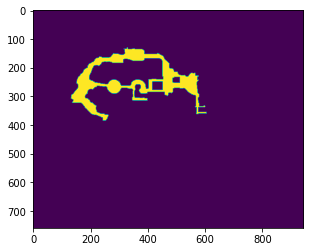

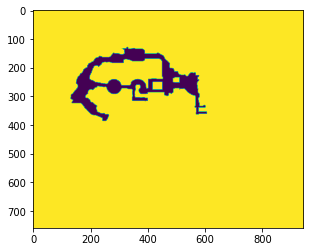

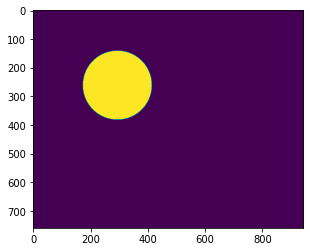

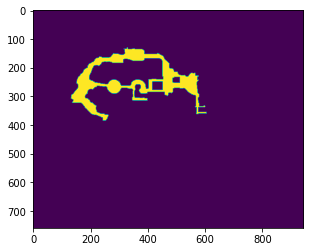

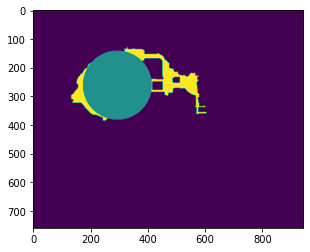

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


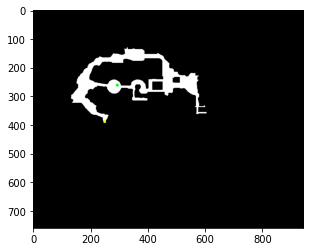

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


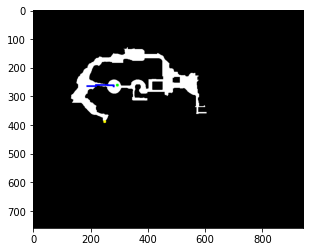

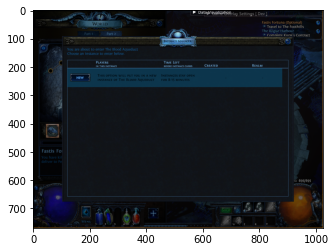

True

In [ ]:
'''
poe_bot.refreshAll()



plt.imshow(poe_bot.passable);plt.show()
plt.imshow(poe_bot.terrain_for_a_star);plt.show()
plt.imshow(poe_bot.visited_area);plt.show()
currently_passable_area = poe_bot.generateCurrentlyPassableArea()
plt.imshow(currently_passable_area);plt.show()
currently_passable_area_for_discovery = currently_passable_area - poe_bot.visited_area
plt.imshow(currently_passable_area_for_discovery);plt.show()
plt.imshow(poe_bot._generateColorfulImage());plt.show()
try:
  plt.imshow(poe_bot._generateColorfulImage(path));plt.show()
except: pass

game_img = poe_bot.getImage()
plt.imshow(game_img);plt.show()
pickle_img = game_img
cv2.imwrite('./inventory_and_chest_opened.bmp', game_img)
'''